In [194]:
import pandas as pd
import seaborn as sns

modes      = ['driving', 'walking', 'bicycling', 'transit']
directions = ['arrival', 'departure']

df = pd.read_csv('../data/results-new-york-city-no-water.csv')

address_columns = [column for column in df.columns if 'address' in column]

for i, row in df.iterrows():
    values = [row[column] for column in address_columns if 'USA' in row[column]]
    if len(set(values)) == 1:
        address = values[0]
        df.loc[i, 'address']  = address
        zip_code = address[len(address)-10:len(address)-5]
        if zip_code.isnumeric():
            df.loc[i, 'zip-code'] = address[len(address)-10:len(address)-5]
        else:
            df.loc[i, 'zip-code'] = None
    else:
        df.loc[i, 'address']  = None
        df.loc[i, 'zip-code'] = None

zip_codes = list(df['zip-code'].unique())
zip_codes.remove(None)

for mode in modes:
    df['{}-distance'.format(mode)] = (df['{}-arrival-distance'.format(mode)] + df['{}-departure-distance'.format(mode)]) / 1000 # Convert from m to km
    df['{}-duration'.format(mode)] = (df['{}-arrival-duration'.format(mode)] + df['{}-departure-duration'.format(mode)]) / 60 # Convert from s to min
    df['{}-speed'.format(mode)]    = ((df['{}-distance'.format(mode)] / 1000) / (df['{}-duration'.format(mode)] / 3600)) # Convert from m/s to km/h

df = df[df['within'] == True]

In [195]:
df_zillow_regions = pd.read_csv('../data/zillow-regions.csv')
zip_code_to_region = {}
for zip_code in zip_codes:
    df_slice = df_zillow_regions[df_zillow_regions['region'].str.contains(zip_code)]
    if len(df_slice) >= 1:
        zip_code_to_region[zip_code] = df_slice.iloc[0, 0]
    else:
        zip_code_to_region[zip_code] = None

In [181]:
import quandl
quandl.ApiConfig.api_key = ""
#quandl.get_table('ZILLOW/INDICATORS').to_csv('../data/zillow-indicators.csv')
#quandl.get_table('ZILLOW/REGIONS').to_csv('../data/zillow-regions.csv')

df_rent = pd.DataFrame()

for zip_code in zip_codes:
    rent = None
    region_id = zip_code_to_region[zip_code]
    if region_id is not None:
        df_zillow = quandl.get_table('ZILLOW/DATA', indicator_id='RSSA', region_id=region_id)
        df_zillow = df_zillow[df_zillow['date'] >= '2019-11-30']
        if len(df_zillow) >= 1:
            rent = df_zillow['value'].mean()
    d = {
        'zip-code': zip_code,
        'rent': rent
    }
    df_rent = df_rent.append(d, ignore_index=True)

df_rent.to_csv('../data/rent-new-york-city.csv', index=False)

In [201]:
df_rent = pd.read_csv('../data/rent-new-york-city.csv')
df_rent['zip-code'] = df_rent['zip-code'].astype(str)
df_merge = pd.merge(df, df_rent, how='outer', on='zip-code')
df_merge.to_csv('test.csv')

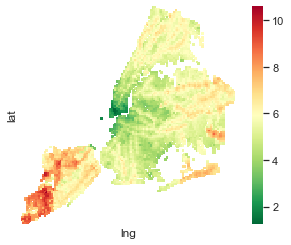

In [63]:
sns.set_style('white')
df_sns = df.pivot('lat', 'lng', 'transit-speed')
df_sns.sort_index(level=0, ascending=False, inplace=True)
ax = sns.heatmap(df_sns, cmap=sns.color_palette('RdYlGn', as_cmap=True).reversed(), square=True, xticklabels=False, yticklabels=False)


<AxesSubplot:xlabel='driving-duration', ylabel='rent'>

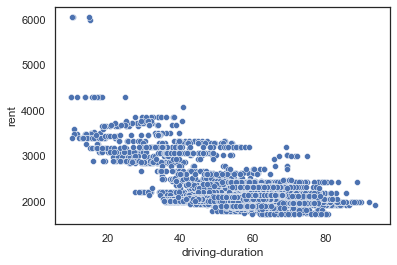

In [205]:
sns.scatterplot(data=df_merge, x='driving-duration', y='rent')
